In [31]:
#  import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from scipy.signal import find_peaks

import yfinance as yf
import numpy as np
from datetime import datetime


In [32]:
# question 1
# URL of the S&P 500 Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Get the page content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the first table (which contains the current S&P 500 companies)
table = soup.find('table', {'class': 'wikitable'})

# Convert the table to a DataFrame
df = pd.read_html(str(table))[0]

# Clean up the column names
df.columns = [col.strip() for col in df.columns]

# Extract year from the 'Date added' column
df['Year Added'] = pd.to_datetime(df['Date added'], errors='coerce').dt.year

# Create a DataFrame with company information
companies_df = df[['Symbol', 'Security', 'Year Added']].copy()
companies_df.columns = ['Ticker', 'Company Name', 'Year Added']

# Calculate number of additions by year
additions_by_year = companies_df['Year Added'].value_counts().sort_index()

# Find the year with the highest number of additions (excluding 1957)
max_additions_year = additions_by_year[additions_by_year.index != 1957].idxmax()
max_additions_count = additions_by_year[max_additions_year]

print(f"Year with highest number of additions (excluding 1957): {max_additions_year}")
print(f"Number of additions in {max_additions_year}: {max_additions_count}")

# Display the first few rows of the companies DataFrame
print("\nFirst few companies in the dataset:")
print(companies_df.head())

# Display the additions by year
print("\nAdditions by year:")
print(additions_by_year)

Year with highest number of additions (excluding 1957): 2016
Number of additions in 2016: 23

First few companies in the dataset:
  Ticker         Company Name  Year Added
0    MMM                   3M        1957
1    AOS          A. O. Smith        2017
2    ABT  Abbott Laboratories        1957
3   ABBV               AbbVie        2012
4    ACN            Accenture        2011

Additions by year:
Year Added
1957    53
1964     1
1965     2
1969     2
1970     2
1972     2
1973     2
1974     1
1975     2
1976    11
1978     1
1979     2
1980     3
1981     3
1982     5
1983     3
1984     5
1985     7
1986     3
1987     2
1988     4
1989     5
1991     1
1992     3
1993     3
1994     7
1995     7
1996     2
1997    14
1998    11
1999     9
2000     9
2001     8
2002    13
2003     5
2004     6
2005     7
2006    10
2007    12
2008    17
2009    12
2010     9
2011    10
2012    14
2013    10
2014     8
2015    14
2016    23
2017    23
2018    14
2019    22
2020    12
2021    15
2022

[*********************100%***********************]  11 of 11 completed

YTD Performance of Major Stock Market Indices (Jan 1, 2025 - May 1, 2025)
       Country     Index  YTD Return (%)
        Mexico      ^MXX           13.05
     Hong Kong      ^HSI           12.72
        Brazil     ^BVSP           12.44
       Germany    ^GDAXI           12.35
United Kingdom     ^FTSE            2.84
         India     ^NSEI            2.49
         China 000001.SS            0.50
        Canada   ^GSPTSE           -0.23
     Australia     ^AXJO           -0.91
 United States     ^GSPC           -5.10
         Japan     ^N225           -8.30


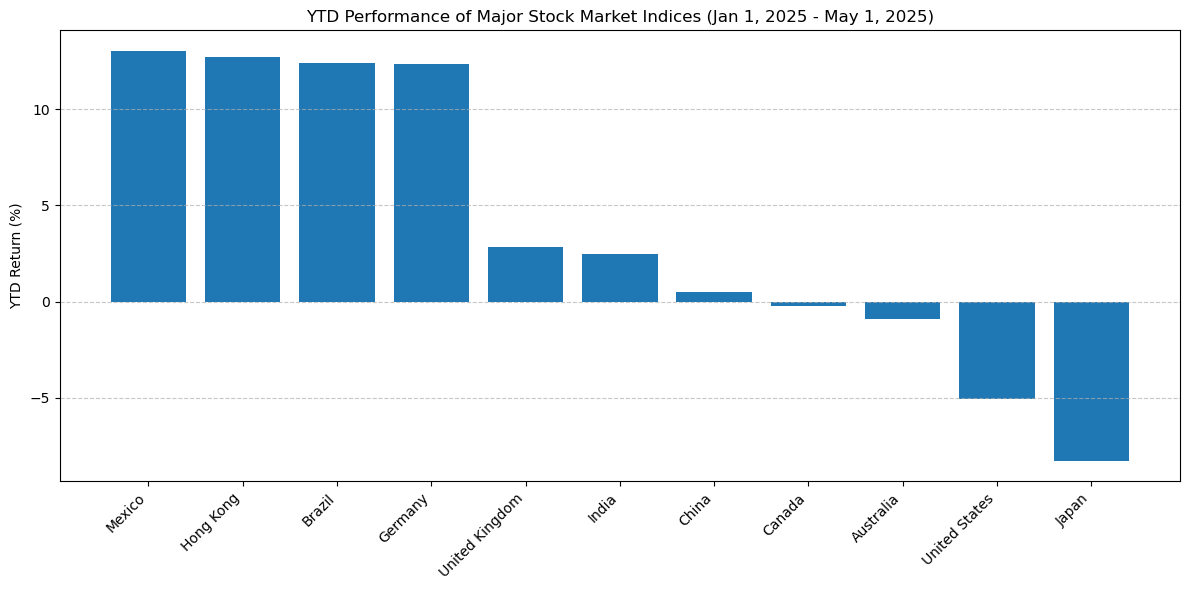

In [33]:
# question 2
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the indices and their symbols
indices = {
    'United States': '^GSPC',
    'China': '000001.SS',
    'Hong Kong': '^HSI',
    'Australia': '^AXJO',
    'India': '^NSEI',
    'Canada': '^GSPTSE',
    'Germany': '^GDAXI',
    'United Kingdom': '^FTSE',
    'Japan': '^N225',
    'Mexico': '^MXX',
    'Brazil': '^BVSP'
}

# Set the date range
start_date = '2025-01-01'
end_date = '2025-05-01'

# Fetch all index data at once
symbols = list(indices.values())
all_data = yf.download(symbols, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

# Prepare results list
results_list = []

for country, symbol in indices.items():
    try:
        # Some indices may have their data as a column MultiIndex, others as a single DataFrame
        if (symbol in all_data.columns.get_level_values(0)):
            close_prices = all_data[symbol]['Close']
        else:
            # fallback for single symbol download
           continue
        # Drop NaNs in case of missing data at start/end
        close_prices = close_prices.dropna()
        if close_prices.empty or len(close_prices) < 2:
            raise ValueError("Not enough data for YTD calculation")
        initial_price = close_prices.iloc[0]
        final_price = close_prices.iloc[-1]
        ytd_return = ((final_price - initial_price) / initial_price) * 100
        results_list.append({
            'Country': country,
            'Index': symbol,
            'YTD Return (%)': round(ytd_return, 2)
        })
    except Exception as e:
        print(f"Error fetching/calculating data for {country} ({symbol}): {str(e)}")

# Create DataFrame and sort
results = pd.DataFrame(results_list)
results = results.sort_values('YTD Return (%)', ascending=False)

# Display results
print("YTD Performance of Major Stock Market Indices (Jan 1, 2025 - May 1, 2025)")
print("=" * 80)
print(results.to_string(index=False))

# Create a bar chart of the results
plt.figure(figsize=(12, 6))
plt.bar(results['Country'], results['YTD Return (%)'])
plt.xticks(rotation=45, ha='right')
plt.title('YTD Performance of Major Stock Market Indices (Jan 1, 2025 - May 1, 2025)')
plt.ylabel('YTD Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
# Question 3. [Index] S&P 500 Market Corrections Analysis
# Download S&P 500 historical data
sp500 = yf.download('^GSPC', start='1950-01-01', end=datetime.now().strftime('%Y-%m-%d')).reset_index()
sp500.columns = sp500.columns.droplevel(1)
# Calculate all-time highs
sp500['AllTimeHigh'] = sp500['Close'].cummax()
sp500['IsAllTimeHigh']=sp500['Close'] == sp500['AllTimeHigh']


# sp500['IsAllTimeHigh']=(sp500['Close'].to_numpy().ravel() == sp500['AllTimeHigh'].to_numpy().ravel())
print((sp500['IsAllTimeHigh'] == True).sum())


# Get all-time high dates
all_time_highs = sp500[sp500['IsAllTimeHigh']].copy()


[*********************100%***********************]  1 of 1 completed

1474


In [35]:
# Initialize lists to store results
high_dates = []
high_prices = []
min_prices = []
min_dates = []
period_durations =[]

# Find minimum prices between consecutive all-time highs
for i in range(len(all_time_highs) - 1):
    current_high_date = all_time_highs.index[i]
    next_high_date = all_time_highs.index[i + 1]
    
    # Get the period between these two highs
    period_data = sp500.loc[current_high_date:next_high_date]
    period_duration = (sp500.loc[next_high_date, 'Date'] - sp500.loc[current_high_date, 'Date']).days
    
    # Find the minimum price in this period
    min_price = period_data['Close'].min()
    min_date = period_data['Close'].idxmin()
    
    # Store results
    high_dates.append(current_high_date)
    high_prices.append(all_time_highs['Close'].iloc[i])
    min_prices.append(min_price)
    min_dates.append(min_date)
    period_durations.append(period_duration)


# Create a DataFrame with the results
results = pd.DataFrame({
    'High Date': high_dates,
    'High Price': high_prices,
    'Min Price': min_prices,
    'Min Date': min_dates,
    'Drawdown Dur':period_durations
    
})
results['Drawdown %'] = (results['High Price'] - results['Min Price']) / results['High Price'] * 100

# Print summary statistics
print("\nSummary of S&P 500 All-Time Highs and Subsequent Minimums:")
print(f"Total number of all-time highs: {len(results)}")
print(f"\nAverage drawdown between highs: {results['Drawdown %'].mean():.2f}%")
print(f"Maximum drawdown: {results['Drawdown %'].max():.2f}%")
print(f"Minimum drawdown: {results['Drawdown %'].min():.2f}%")

# Save results to CSV
# results.to_csv('sp500_highs_and_mins.csv')
# print("\nResults have been saved to 'sp500_highs_and_mins.csv'")
results_with_large_drawdown=results[results['Drawdown %']>=5]
print("25th percentile of Drawdown Dur:", results_with_large_drawdown['Drawdown Dur'].quantile(0.25))
print("50th percentile (median) of Drawdown Dur:", results_with_large_drawdown['Drawdown Dur'].quantile(0.5))
print("75th percentile of Drawdown Dur:", results_with_large_drawdown['Drawdown Dur'].quantile(0.75))


Summary of S&P 500 All-Time Highs and Subsequent Minimums:
Total number of all-time highs: 1473

Average drawdown between highs: 1.03%
Maximum drawdown: 56.78%
Minimum drawdown: 0.00%
25th percentile of Drawdown Dur: 56.0
50th percentile (median) of Drawdown Dur: 94.0
75th percentile of Drawdown Dur: 213.5


In [36]:
eps_amzn_df = pd.read_csv('./01-intro-and-data-sources/ha1_Amazon.csv', sep=';')


eps_amzn_df.columns = eps_amzn_df.columns.str.lower()
eps_amzn_df.columns = eps_amzn_df.columns.str.replace(' ', '_')
# Convert 'eps_estimate', 'reported_eps', and 'surprise_(%)' to float, replacing non-numeric values with NaN
cols_to_convert = ['eps_estimate', 'reported_eps', 'surprise_(%)']
for col in cols_to_convert:
    eps_amzn_df[col] = pd.to_numeric(eps_amzn_df[col], errors='coerce')



In [37]:
from dateutil import parser

def parse_date(x):
    if pd.isna(x):  # Check if the value is NaN
        return pd.NaT  # Return Not a Time for NaN values
    try:
        return parser.parse(x).date()
    except:
        return pd.NaT

# Apply the function to the column
eps_amzn_df['Date'] =pd.to_datetime(eps_amzn_df['earnings_date'].apply(parse_date),errors='coerce')
eps_amzn_df.head()

,symbol,company,earnings_date,eps_estimate,reported_eps,surprise_(%),Date
0,AMZN,Amazon.com Inc,"April 29, 2026 at 6 AM EDT",NaN,NaN,NaN,2026-04-29
1,AMZN,Amazon.com Inc,"February 4, 2026 at 4 PM EST",NaN,NaN,NaN,2026-02-04
2,AMZN,Amazon.com Inc,"October 29, 2025 at 6 AM EDT",NaN,NaN,NaN,2025-10-29
3,AMZN,Amazon.com Inc,"July 30, 2025 at 4 PM EDT",NaN,NaN,NaN,2025-07-30
4,AMZN,"Amazon.com, Inc.","May 1, 2025 at 4 PM EDT",NaN,NaN,16.74,2025-05-01


In [38]:
pos_sur_eps_amzn_df=eps_amzn_df[eps_amzn_df['surprise_(%)'].astype(float)>0]
pos_sur_eps_amzn_df.head()


,symbol,company,earnings_date,eps_estimate,reported_eps,surprise_(%),Date
4,AMZN,"Amazon.com, Inc.","May 1, 2025 at 4 PM EDT",NaN,NaN,16.74,2025-05-01
5,AMZN,"Amazon.com, Inc.","February 6, 2025 at 4 PM EST",NaN,NaN,24.47,2025-02-06
6,AMZN,"Amazon.com, Inc.","October 31, 2024 at 4 PM EDT",NaN,NaN,25.17,2024-10-31
7,AMZN,"Amazon.com, Inc.","August 1, 2024 at 4 PM EDT",NaN,NaN,22.58,2024-08-01
8,AMZN,"Amazon.com, Inc.","April 30, 2024 at 4 PM EDT",0.83,0.98,17.91,2024-04-30


In [39]:
amzn_df = yf.download('amzn', start='1950-01-01', end=datetime.now().strftime('%Y-%m-%d')).reset_index()
amzn_df.columns = amzn_df.columns.droplevel(1)
amzn_df['Date'] =pd.to_datetime(amzn_df['Date'],errors='coerce')
amzn_df.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,1997-05-15,0.097917,0.125000,0.096354,0.121875,1443120000
1,1997-05-16,0.086458,0.098958,0.085417,0.098438,294000000
2,1997-05-19,0.085417,0.088542,0.081250,0.088021,122136000
3,1997-05-20,0.081771,0.087500,0.081771,0.086458,109344000
4,1997-05-21,0.071354,0.082292,0.068750,0.081771,377064000


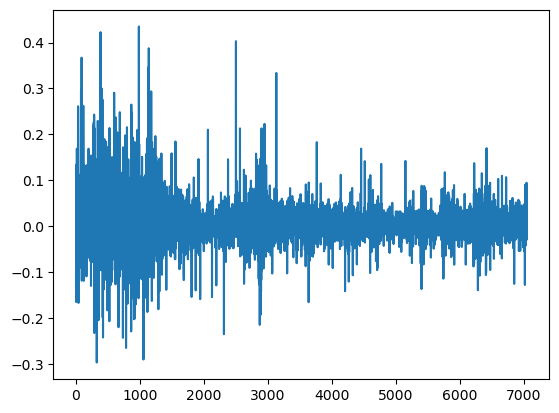

In [40]:
amzn_df['two_day_pct_change'] = amzn_df['Close'].pct_change(2)
amzn_df['two_day_pct_change'].plot()
plt.show()

In [41]:
# question 4

amzn_df = amzn_df.reset_index(drop=True)
amzn_df_shifted = amzn_df.shift(-1)
amzn_df_shifted['Date'] = amzn_df['Date']  # Use original Date as join key

pos_sur_eps_amzn_merged_df = pos_sur_eps_amzn_df.merge(
    amzn_df_shifted,
    on='Date',
    how='left'
)


Correlation between EPS Surprise and Two Day % Change: 0.224 (p-value: 0.0378)
median of two day pct change around eps report with positive surprise: 0.010
median of two day pct change all dates: 0.002


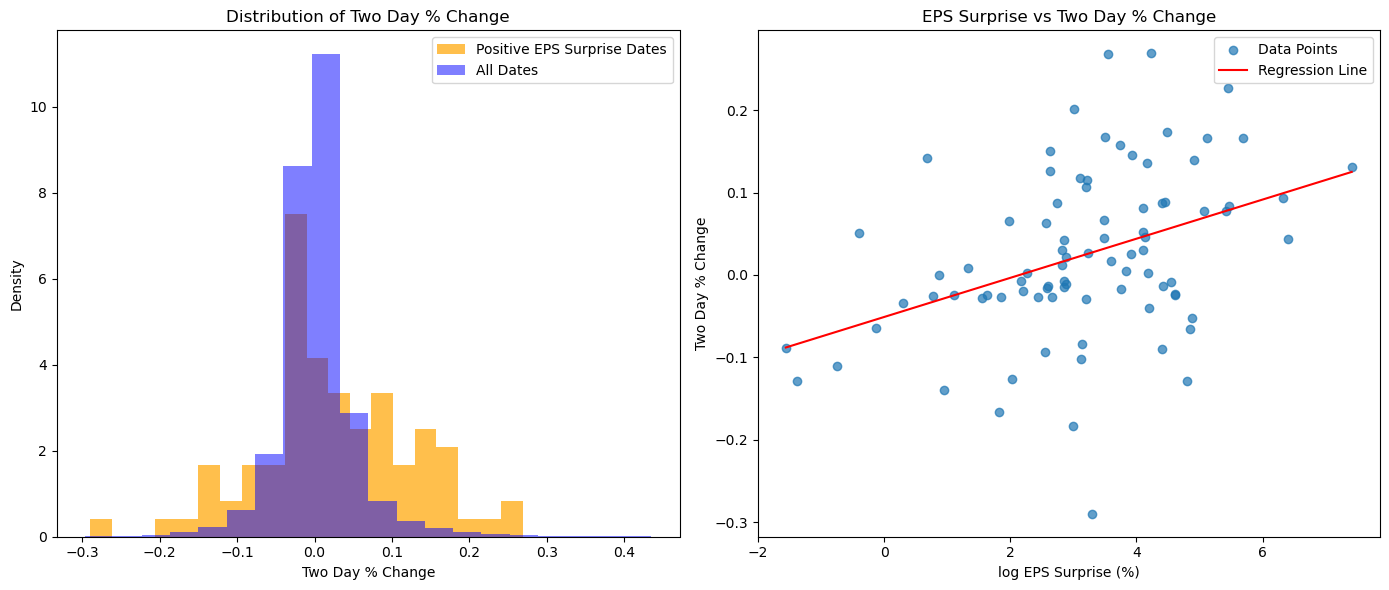

In [42]:
# question 4
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Scatter plot of absolute surprise vs two_day_pct_change
# Plot density histograms of two_day_pct_change for both positive surprise EPS dates and all dates, overlaid
ax[0].hist(
    pos_sur_eps_amzn_merged_df['two_day_pct_change'].dropna(),
    bins=20,
    density=True,
    alpha=0.7,
    color='orange',
    label='Positive EPS Surprise Dates'
)
ax[0].hist(
    amzn_df['two_day_pct_change'].dropna(),
    bins=20,
    density=True,
    alpha=0.5,
    color='blue',
    label='All Dates'
)
ax[0].set_xlabel('Two Day % Change')
ax[0].set_ylabel('Density')
ax[0].set_title('Distribution of Two Day % Change')
ax[0].legend()



# Subplot 2: Scatter plot of surprise vs two_day_pct_change
x = np.log(pos_sur_eps_amzn_merged_df['surprise_(%)'].astype(float))
y = pos_sur_eps_amzn_merged_df['two_day_pct_change']

ax[1].scatter(
    x,
    y,
    alpha=0.7,
    label='Data Points'
)

# Add regression line# Remove NaNs for regression
mask = (~x.isna()) & (~y.isna())
x_clean = x[mask]
y_clean = y[mask]
if len(x_clean) > 1:
    m, b = np.polyfit(x_clean, y_clean, 1)
    x_vals = np.linspace(x_clean.min(), x_clean.max(), 100)
    y_vals = m * x_vals + b
    ax[1].plot(x_vals, y_vals, color='red', label='Regression Line')

ax[1].set_xlabel('log EPS Surprise (%)')
ax[1].set_ylabel('Two Day % Change')
ax[1].set_title('EPS Surprise vs Two Day % Change')
ax[1].legend()
# Calculate and print correlation
from scipy.stats import pearsonr

# Drop rows with NaN values in the relevant columns and convert to float
valid = pos_sur_eps_amzn_merged_df[['surprise_(%)', 'two_day_pct_change']].dropna().astype(float)
corr, pval = pearsonr(valid['surprise_(%)'], valid['two_day_pct_change'])
print(f"Correlation between EPS Surprise and Two Day % Change: {corr:.3f} (p-value: {pval:.3g})")
print(f"median of two day pct change around eps report with positive surprise: {pos_sur_eps_amzn_merged_df['two_day_pct_change'].median():1.3f}")
print(f"median of two day pct change all dates: {amzn_df['two_day_pct_change'].median():1.3f}")

plt.tight_layout()


plt.show()



/var/folders/53/hnkr1cdj0l52pdybl21x__fr0000gn/T/ipykernel_35883/2091361176.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['bullbear_ind'][0:peaks[0]]=0.5


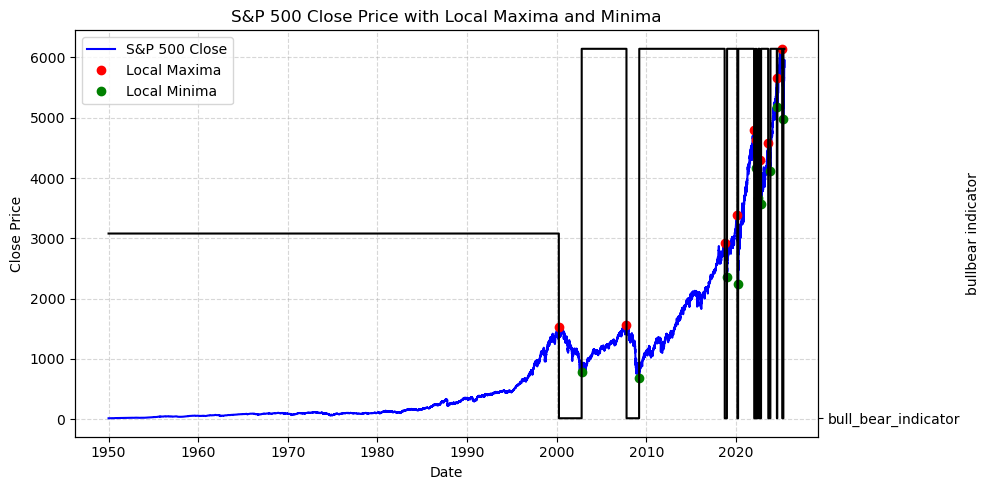

In [43]:
# question 4
# determine bull and bear periods (my simple defintion from peak to trough is bear and from trough to peak is bull)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot S&P 500 Close price
ax.plot(sp500['Date'], sp500['Close'], label='S&P 500 Close', color='blue')

# Find local maxima (peaks) with high prominence
peaks, _ = find_peaks(sp500['Close'], prominence=sp500['Close'].std()/3)
# Find local minima (valleys) with high prominence by inverting the signal
valleys, _ = find_peaks(-sp500['Close'], prominence=sp500['Close'].std()/3)
sp500['peakval_ind'] = 0
sp500.loc[peaks, 'peakval_ind'] = 1
sp500.loc[valleys, 'peakval_ind']=-1
sp500['bullbear_ind']=1-sp500['peakval_ind'].cumsum()
sp500['bullbear_ind'][0:peaks[0]]=0.5
# Plot local maxima
ax.plot(sp500['Date'].iloc[peaks], sp500['Close'].iloc[peaks], 'ro', label='Local Maxima')
# Plot local minima
ax.plot(sp500['Date'].iloc[valleys], sp500['Close'].iloc[valleys], 'go', label='Local Minima')

ax0=ax.twinx()
ax0.plot(sp500['Date'],sp500['bullbear_ind'],'k','bull_bear_indicator')
ax0.set_ylabel('bullbear indicator')

ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.title('S&P 500 Close Price with Local Maxima and Minima')
plt.tight_layout()
plt.show()

Stats for (Bear Market)
Correlation between EPS Surprise and Two Day % Change: 0.531 (p-value: 0.0133)
median of two day pct change around eps report with positive surprise: 0.002
median of two day pct change all dates: 0.002
Stats for (Bull Market)
Correlation between EPS Surprise and Two Day % Change: 0.210 (p-value: 0.123)
median of two day pct change around eps report with positive surprise: 0.026
median of two day pct change all dates: 0.002


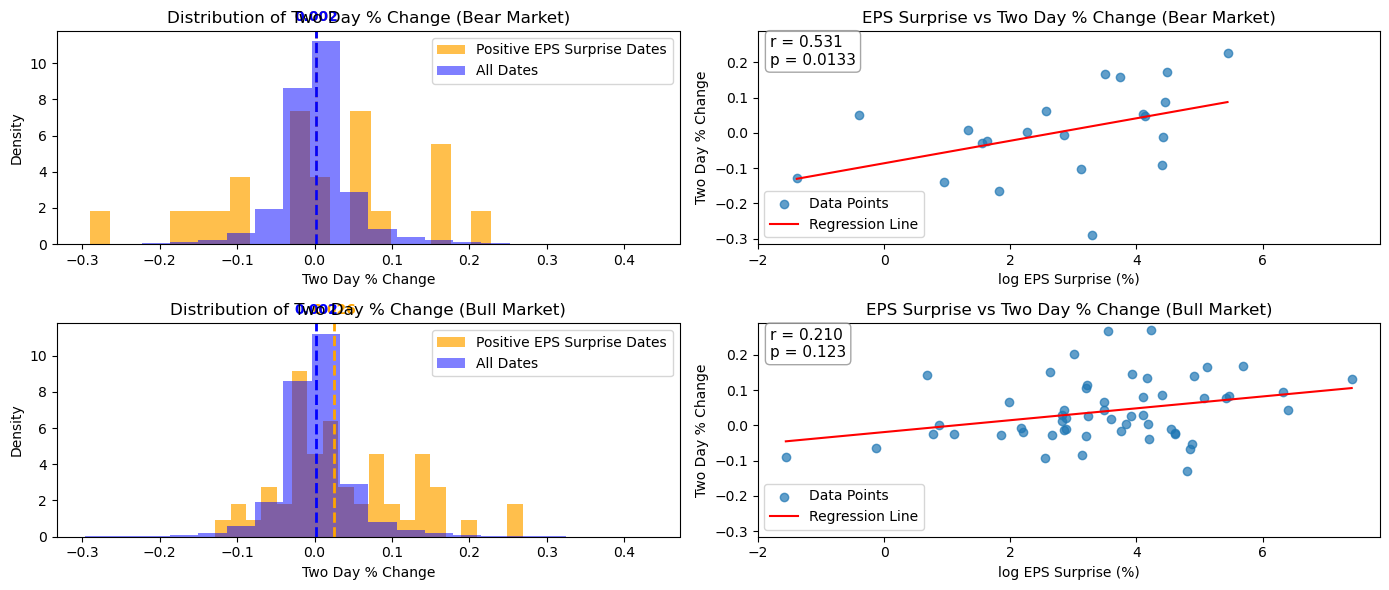

In [44]:
# question 4
# separately analyze for bull and bear markets
fig, ax = plt.subplots(2, 2, figsize=(14, 6))

# To store x/y limits for ax[0,1] and ax[1,1]
xmins, xmaxs, ymins, ymaxs = [], [], [], []

for i in range(0, 2):
    forplot_df = pos_sur_eps_amzn_merged_df[pos_sur_eps_amzn_merged_df['Date'].isin(sp500['Date'][sp500['bullbear_ind']==i])]
    
    # Subplot 1: Histograms
    n1, bins1, patches1 = ax[i,0].hist(
        forplot_df['two_day_pct_change'].dropna(),
        bins=20,
        density=True,
        alpha=0.7,
        color='orange',
        label='Positive EPS Surprise Dates'
    )
    n2, bins2, patches2 = ax[i,0].hist(
        amzn_df['two_day_pct_change'].dropna(),
        bins=20,
        density=True,
        alpha=0.5,
        color='blue',
        label='All Dates'
    )
    ax[i,0].set_xlabel('Two Day % Change')
    ax[i,0].set_ylabel('Density')
    ax[i,0].set_title(f'Distribution of Two Day % Change ({"Bear" if i==0 else "Bull"} Market)')
    ax[i,0].legend()

    # Add median markers and annotate
    # For positive EPS surprise dates
    median_pos = forplot_df['two_day_pct_change'].dropna().median()
    ylim = ax[i,0].get_ylim()
    ax[i,0].axvline(median_pos, color='orange', linestyle='--', linewidth=2, label='Median (Pos EPS)')
    ax[i,0].annotate(f"{median_pos:.3f}", 
                     xy=(median_pos, ylim[1]), 
                     xytext=(0,5), 
                     textcoords='offset points',
                     ha='center', va='bottom', color='orange', fontsize=10, fontweight='bold')
    # For all dates
    median_all = amzn_df['two_day_pct_change'].dropna().median()
    ax[i,0].axvline(median_all, color='blue', linestyle='--', linewidth=2, label='Median (All)')
    ax[i,0].annotate(f"{median_all:.3f}", 
                     xy=(median_all, ylim[1]), 
                     xytext=(0,5), 
                     textcoords='offset points',
                     ha='center', va='bottom', color='blue', fontsize=10, fontweight='bold')

    # Subplot 2: Scatter plot
    x = np.log(forplot_df['surprise_(%)'].astype(float))
    y = forplot_df['two_day_pct_change']

    ax[i,1].scatter(
        x,
        y,
        alpha=0.7,
        label='Data Points'
    )

    # Add regression line
    mask = (~x.isna()) & (~y.isna())
    x_clean = x[mask]
    y_clean = y[mask]
    if len(x_clean) > 1:
        m, b = np.polyfit(x_clean, y_clean, 1)
        x_vals = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_vals = m * x_vals + b
        ax[i,1].plot(x_vals, y_vals, color='red', label='Regression Line')

    # Calculate correlation and p-value
    valid = forplot_df[['surprise_(%)', 'two_day_pct_change']].dropna().astype(float)
    if len(valid) > 1:
        corr, pval = pearsonr(valid['surprise_(%)'], valid['two_day_pct_change'])
        corr_text = f"r = {corr:.3f}\np = {pval:.3g}"
    else:
        corr_text = "Not enough data"
    
    # Annotate correlation and p-value on scatter plot
    # Place in upper left of the axes
    ax[i,1].annotate(
        corr_text,
        xy=(0.02, 0.98),
        xycoords='axes fraction',
        ha='left', va='top',
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
    )

    ax[i,1].set_xlabel('log EPS Surprise (%)')
    ax[i,1].set_ylabel('Two Day % Change')
    ax[i,1].set_title(f'EPS Surprise vs Two Day % Change ({"Bear" if i==0 else "Bull"} Market)')
    ax[i,1].legend()
    
    # Store x/y limits for later
    cur_xlim = ax[i,1].get_xlim()
    cur_ylim = ax[i,1].get_ylim()
    xmins.append(cur_xlim[0])
    xmaxs.append(cur_xlim[1])
    ymins.append(cur_ylim[0])
    ymaxs.append(cur_ylim[1])
    
    # Calculate and print correlation (for console)
    print(f'Stats for ({"Bear" if i==0 else "Bull"} Market)')
    print(f"Correlation between EPS Surprise and Two Day % Change: {corr:.3f} (p-value: {pval:.3g})" if len(valid) > 1 else "Not enough data for correlation")
    print(f"median of two day pct change around eps report with positive surprise: {median_pos:1.3f}")
    print(f"median of two day pct change all dates: {median_all:1.3f}")

# After the loop, set the same x/y range for both ax[0,1] and ax[1,1]
common_xlim = (min(xmins), max(xmaxs))
common_ylim = (min(ymins), max(ymaxs))
ax[0,1].set_xlim(common_xlim)
ax[1,1].set_xlim(common_xlim)
ax[0,1].set_ylim(common_ylim)
ax[1,1].set_ylim(common_ylim)

plt.tight_layout()
plt.show()